# Recommendation system using matrix factorization

> Conributed by Manjal Shah (202003037)


In [1]:
# Importing libraries
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Loading data

In [2]:
# Here, I have taken first 2 M rows of the review dataset as working with such a huge dataset is not feasible in this colab due to RAM limit.
N = 2000000
data_reviews = []
with gzip.open('/content/drive/MyDrive/RS/reviews.clean.json.gz') as f:
    head = [next(f) for x in range(N)]
    for l in head:
        data_reviews.append(eval(l))

In [3]:
reviews_df = pd.DataFrame.from_dict(data_reviews)
print(reviews_df.shape)
reviews_df.head()

(2000000, 8)


,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId
0,3.0,an lam,Chất lượng tạm ổn,[Giải Trí - Café],108103314380004200232,1.372687e+09,"Jul 1, 2013",100000010817154263736
1,5.0,HALİL TURGUT,Wc si temiz duzenli..,[Turkish Cuisine],102194128241608748649,1.342871e+09,"Jul 21, 2012",100000013500285534661
2,5.0,森田さとこ,何回も私は予定に休みがセルバに行ったので覚えて見て、分かります❗,"[Fishing, Pond Fish Supplier, Seafood Market]",101409858828175402384,1.390654e+09,"Jan 25, 2014",100000021336848867366
3,5.0,森田さとこ,今度は予定に休みが登米市に行きたい❗☀😅🌌 楽しいに日帰りに登米の見学の観光(*^)(*^-...,[Museum],101477177500158511502,1.389188e+09,"Jan 8, 2014",100000021336848867366
4,4.0,森田さとこ,気仙沼警察署に移転中に絆 👮🐎☺🙋🚓頑張ろう❗,[Police],106994170641063333085,1.390486e+09,"Jan 23, 2014",100000021336848867366


In [6]:
reviews_df['rating'].value_counts()

5.0    996224
4.0    469472
3.0    267008
2.0    160945
1.0    106347
0.0         4
Name: rating, dtype: int64

Ideally, rating should be from 1 to 5 but in this sample, we have 4 entries with 0 values. I have considered this 0 rating as unrated for further calculations.

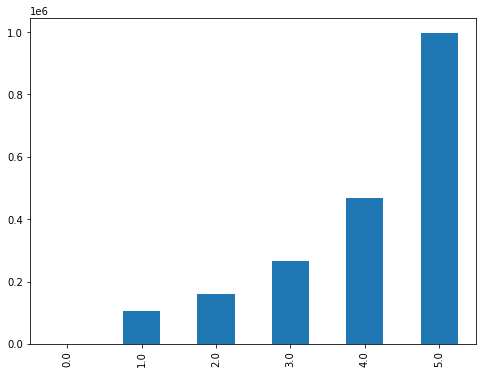

In [5]:
plt.figure(figsize=(8,6))
reviews_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.show()

It seems like the given data is biased towards higher rating

In [7]:
reviews_df['gPlusPlaceId'].value_counts()

118197036100848201903    291
113708963026857003945    178
107836749011706685871    132
104102841184199673397    117
105221456964199450690    114
                        ... 
114629527316779088457      1
100999149175912432146      1
108818051855215599021      1
109049741451432742440      1
113249899068270935270      1
Name: gPlusPlaceId, Length: 1185579, dtype: int64

In [8]:
reviews_df['gPlusUserId'].value_counts()

100689039355298728862    3221
102358706157964192105    1250
103181082640529739640    1090
100811926915679245476    1062
100961288997176421259    1018
                         ... 
101258534153020429014       1
101258540494234862539       1
101258546119039869333       1
101258562235777108394       1
101595673870060127113       1
Name: gPlusUserId, Length: 872227, dtype: int64

From both of these columns, we can see that there are very few places and users with higher number of appearance in the data. So, user-item matrix created from this data will be very much sparce in nature. To avoid that, we will filter out the data.

In [9]:
# Transforming the category column in a proper format
reviews_df = reviews_df.explode('categories')
reviews_df = reviews_df.dropna(subset = ["categories"])

In [10]:
reviews_df = reviews_df.loc[reviews_df["categories"].str.endswith('Restaurant')]  # considering only those reviews which are rated to a restaurant

In [11]:
filter_df = reviews_df[reviews_df.groupby("gPlusUserId")["categories"].transform("size")>10]  # considering only those users who have rated greater then 10 times
final_df = filter_df[filter_df.groupby("categories")["gPlusUserId"].transform("size")>3]  # considering only those restaurants which have been rated greater then 3 times

In [12]:
final_df = final_df[final_df['categories']!='Restaurant']      # removing the restaurant category
final_df.reset_index(drop=True, inplace=True)
final_df

,rating,reviewerName,reviewText,categories,gPlusPlaceId,unixReviewTime,reviewTime,gPlusUserId
0,5.0,Marce Castro,Un restaurante situado al lado del metro Tribu...,Spanish Restaurant,101629152433762263081,1.386839e+09,"Dec 12, 2013",100000242929724813348
1,5.0,Marce Castro,Un restaurante situado al lado del metro Tribu...,European Restaurant,101629152433762263081,1.386839e+09,"Dec 12, 2013",100000242929724813348
2,4.0,Marce Castro,Otro de mis pubs irlandeses favoritos en la zo...,European Restaurant,103008023740714806432,1.386840e+09,"Dec 12, 2013",100000242929724813348
3,5.0,Marce Castro,Descubrí este sitio con unos amigos que habían...,Polish Restaurant,103127515730297321538,1.386231e+09,"Dec 5, 2013",100000242929724813348
4,4.0,Marce Castro,"Soy fan del sandwich de pavo con manzana, aunq...",Fast Food Restaurant,103356128476094784121,1.380048e+09,"Sep 24, 2013",100000242929724813348
...,...,...,...,...,...,...,...,...
367927,5.0,Nicolas Adrian,None,Mediterranean Restaurant,117142217323564372841,1.315069e+09,"Sep 3, 2011",103185877761415724929
367928,5.0,Nicolas Adrian,None,Israeli Restaurant,117142217323564372841,1.315069e+09,"Sep 3, 2011",103185877761415724929
367929,5.0,Nicolas Adrian,None,Latin American Restaurant,117539254378304719441,1.289961e+09,"Nov 16, 2010",103185877761415724929
367930,5.0,Nicolas Adrian,None,Mexican Restaurant,117539254378304719441,1.289961e+09,"Nov 16, 2010",103185877761415724929


In [13]:
final_df = final_df[['rating', 'categories', 'gPlusUserId']]    # Removing unnecessary columns from the data
final_df.describe(include='all')

,rating,categories,gPlusUserId
count,367932.000000,367932,367932
unique,NaN,239,14647
top,NaN,American Restaurant,100961288997176421259
freq,NaN,36434,853
mean,3.914291,NaN,NaN
std,1.020134,NaN,NaN
min,0.000000,NaN,NaN
25%,3.000000,NaN,NaN
50%,4.000000,NaN,NaN
75%,5.000000,NaN,NaN


American Restaurant is the most reviewed category and user with user ID 100961288997176421259 has reviewed the highest number of times in this data. Total 239 unique categories and 14647 unique users are present in this data.

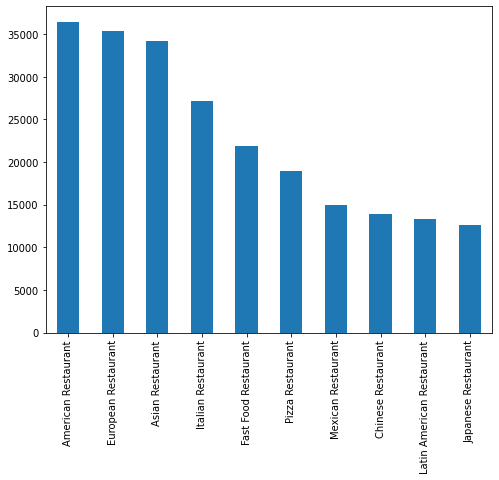

In [14]:
# Here are the top 10 categories in terms of number of received reviews

plt.figure(figsize=(8,6))
final_df['categories'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

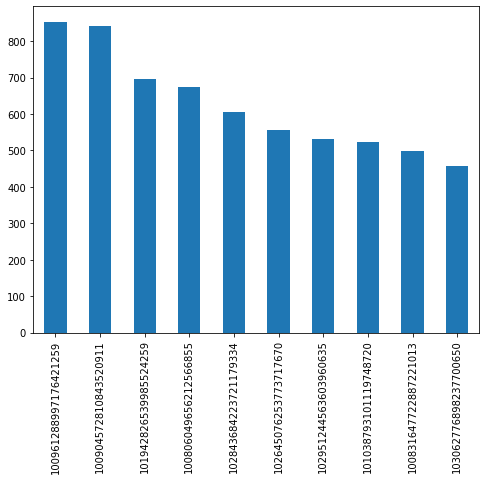

In [15]:
# Here are the top 10 users in terms of number of given reviews

plt.figure(figsize=(8,6))
final_df['gPlusUserId'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

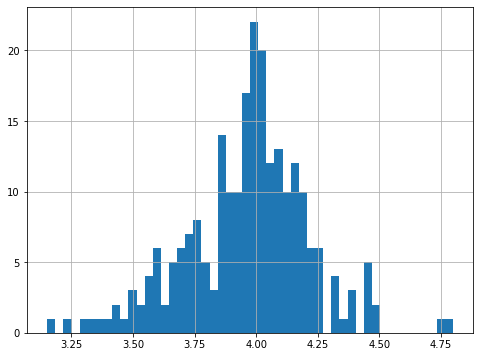

In [16]:
# Here is a histogram of average rating for all the categories

plt.figure(figsize=(8,6))
final_df.groupby('categories')['rating'].mean().sort_values(ascending=False).hist(bins=50)
plt.show()

It looks like a normal distribution with mean = 4, min =3 and max = 5.

In [17]:
users = sorted(final_df['gPlusUserId'].unique())             # Getting unique users
categories = sorted(final_df['categories'].unique())         # Getting unique categories 
user_to_idx = {o:i for i,o in enumerate(users)}              # Creating a dictionary of users and their index
category_to_idx = {o:i for i,o in enumerate(categories)}     # Creating a dictionary of categories and their index
idx_to_category = {i:o for i,o in enumerate(categories)}     

In [18]:
# Transforming user ID and category columns
final_df['gPlusUserId'] = final_df['gPlusUserId'].apply(lambda x: user_to_idx[x])  
final_df['categories'] = final_df['categories'].apply(lambda x: category_to_idx[x])
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367932 entries, 0 to 367931
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   rating       367932 non-null  float64
 1   categories   367932 non-null  int64  
 2   gPlusUserId  367932 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 8.4 MB


In [19]:
util_df = pd.pivot_table(data=final_df,values='rating',index='gPlusUserId',columns='categories')
util_df

categories,0,1,2,3,4,5,6,7,8,9,...,229,230,231,232,233,234,235,236,237,238
gPlusUserId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,4.000000,NaN,...,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.545455,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,4.666667,NaN,NaN,NaN,NaN,4.000000,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,3.333333,NaN,NaN,NaN,NaN,3.139535,NaN,...,4.0,NaN,NaN,NaN,NaN,3.3,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14643,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
util_df.fillna(0, inplace=True)
util_df

categories,0,1,2,3,4,5,6,7,8,9,...,229,230,231,232,233,234,235,236,237,238
gPlusUserId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,5.000000,0.0,0.0,0.0,0.0,4.000000,0.0,...,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.545455,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,4.666667,0.0,0.0,0.0,0.0,4.000000,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,3.333333,0.0,0.0,0.0,0.0,3.139535,0.0,...,4.0,0.0,0.0,0.0,0.0,3.3,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14642,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14643,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14644,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def matrix_factorization(R, P, Q, K, steps=30, alpha=0.02, beta=0.02):

    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])  # calculate error

                    for k in range(K):
                        # calculate gradient with alpha and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)

        rmse = np.sqrt(e/len(R[R>0]))
        print('step :', step+1, 'RMSE :', rmse)
        if rmse < 0.01:
            break

    return P, Q.T

In [22]:
R = np.array(util_df)
N = len(R)                  # Number of Users
M = len(R[0])               # Number of categories
K = 10                      # Number of Features

# Initialize P and Q
P = np.random.rand(N, K)
Q = np.random.rand(M, K)

nP, nQ = matrix_factorization(R, P, Q.T, K)
nR = np.dot(nP, nQ.T)

step : 1 RMSE : 0.8143062303385831
step : 2 RMSE : 0.7930101154294453
step : 3 RMSE : 0.7910601398318277
step : 4 RMSE : 0.7858842078768836
step : 5 RMSE : 0.7682135628059269
step : 6 RMSE : 0.7446364150013034
step : 7 RMSE : 0.7190656786127244
step : 8 RMSE : 0.6953566509544228
step : 9 RMSE : 0.67425914985434
step : 10 RMSE : 0.6553564489839807
step : 11 RMSE : 0.6387345380001967
step : 12 RMSE : 0.6243635303000962
step : 13 RMSE : 0.6118833669709293
step : 14 RMSE : 0.6009109398836477
step : 15 RMSE : 0.5911473598469258
step : 16 RMSE : 0.5823735381980739
step : 17 RMSE : 0.5744303818026417
step : 18 RMSE : 0.5672009874514373
step : 19 RMSE : 0.5605962786507589
step : 20 RMSE : 0.5545449944367318
step : 21 RMSE : 0.5489876504604515
step : 22 RMSE : 0.5438731881230685
step : 23 RMSE : 0.5391570870529987
step : 24 RMSE : 0.5348001599955862
step : 25 RMSE : 0.5307676522469799
step : 26 RMSE : 0.527028509391202
step : 27 RMSE : 0.5235547812131472
step : 28 RMSE : 0.520321155160997
step 

In [23]:
# Recommend categories which user has not rated yet
def recommend(user_id, nR, util_df, user_to_idx, idx_to_category, n=10):
    user_ind = user_to_idx[user_id]          
    # Get the list of categories that the user has not rated
    unrated_categories = util_df.loc[user_ind][util_df.loc[user_ind] == 0].index

    # predicting and storing rating for unrated categories for given user
    unrated_categories_df = pd.DataFrame()
    unrated_categories_df['category'] = [idx_to_category[i] for i in unrated_categories]
    unrated_categories_df['rating'] = nR[user_ind][unrated_categories]

    # Sort the categories by predicted rating
    unrated_categories_df = unrated_categories_df.sort_values(by='rating', ascending=False).reset_index(drop=True)
    return unrated_categories_df[:n]

In [25]:
recommend('100000524810171549476', nR, util_df, user_to_idx, idx_to_category)

,category,rating
0,Dessert Restaurant,6.981001
1,Hot Dog Restaurant,6.651356
2,Cheesesteak Restaurant,6.564764
3,Afghani Restaurant,6.541305
4,Asian Fusion Restaurant,6.324241
5,Modern French Restaurant,6.277112
6,Ethiopian Restaurant,6.247972
7,Soul Food Restaurant,6.220722
8,East African Restaurant,6.206437
9,African Restaurant,6.193673


# References

> https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b
> https://github.com/akshayreddykotha/rating-prediction-google-local
